In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

import math
import torch
import pickle
import seaborn as sns
import torch.nn as nn
import missingno as msno 
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from tqdm import tqdm
#from fastparquet import ParquetFile
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# 1. Загрузка данных:

In [3]:
# Чтение и преобразование первого parquet-файла
df = pd.read_parquet('train_data_0.pq')

columns = df.columns[1:]

for column in columns:
    df[column] = df[column].astype('int8')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19  

In [4]:
# Чтение и преобразование остальных parquet-файлов
files = ['train_data_1.pq', 'train_data_2.pq', 'train_data_3.pq',
        'train_data_4.pq', 'train_data_5.pq', 'train_data_6.pq', 'train_data_7.pq',
        'train_data_8.pq', 'train_data_9.pq', 'train_data_10.pq', 'train_data_11.pq']

for file in files:
    df_file = pd.read_parquet(file)
    
    for column in columns:
        df_file[column] = df_file[column].astype('int8')
        
    df = pd.concat([df, df_file], axis=0)

del df_file
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26162717 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19  is_z

In [5]:
# Размерность полученного датасета
df.shape

(26162717, 61)

In [6]:
# Сохранение полученного датасета в pickle-файл
filename = 'df.pickle'

with open(filename, 'wb') as file:
    pickle.dump(df, file)

In [6]:
# Чтение всего датасета из pickle-файла
df = pd.read_pickle('/kaggle/input/df-pickle/df.pickle')
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


# 2. Data Preparation:

## 2.1. Data Cleaning:

### 2.1.1. Проверка на дубликаты:

In [4]:
# Выводим общее колчество задублированных строк
df.duplicated().sum()

0

### 2.1.2. Проверка на пропуски:

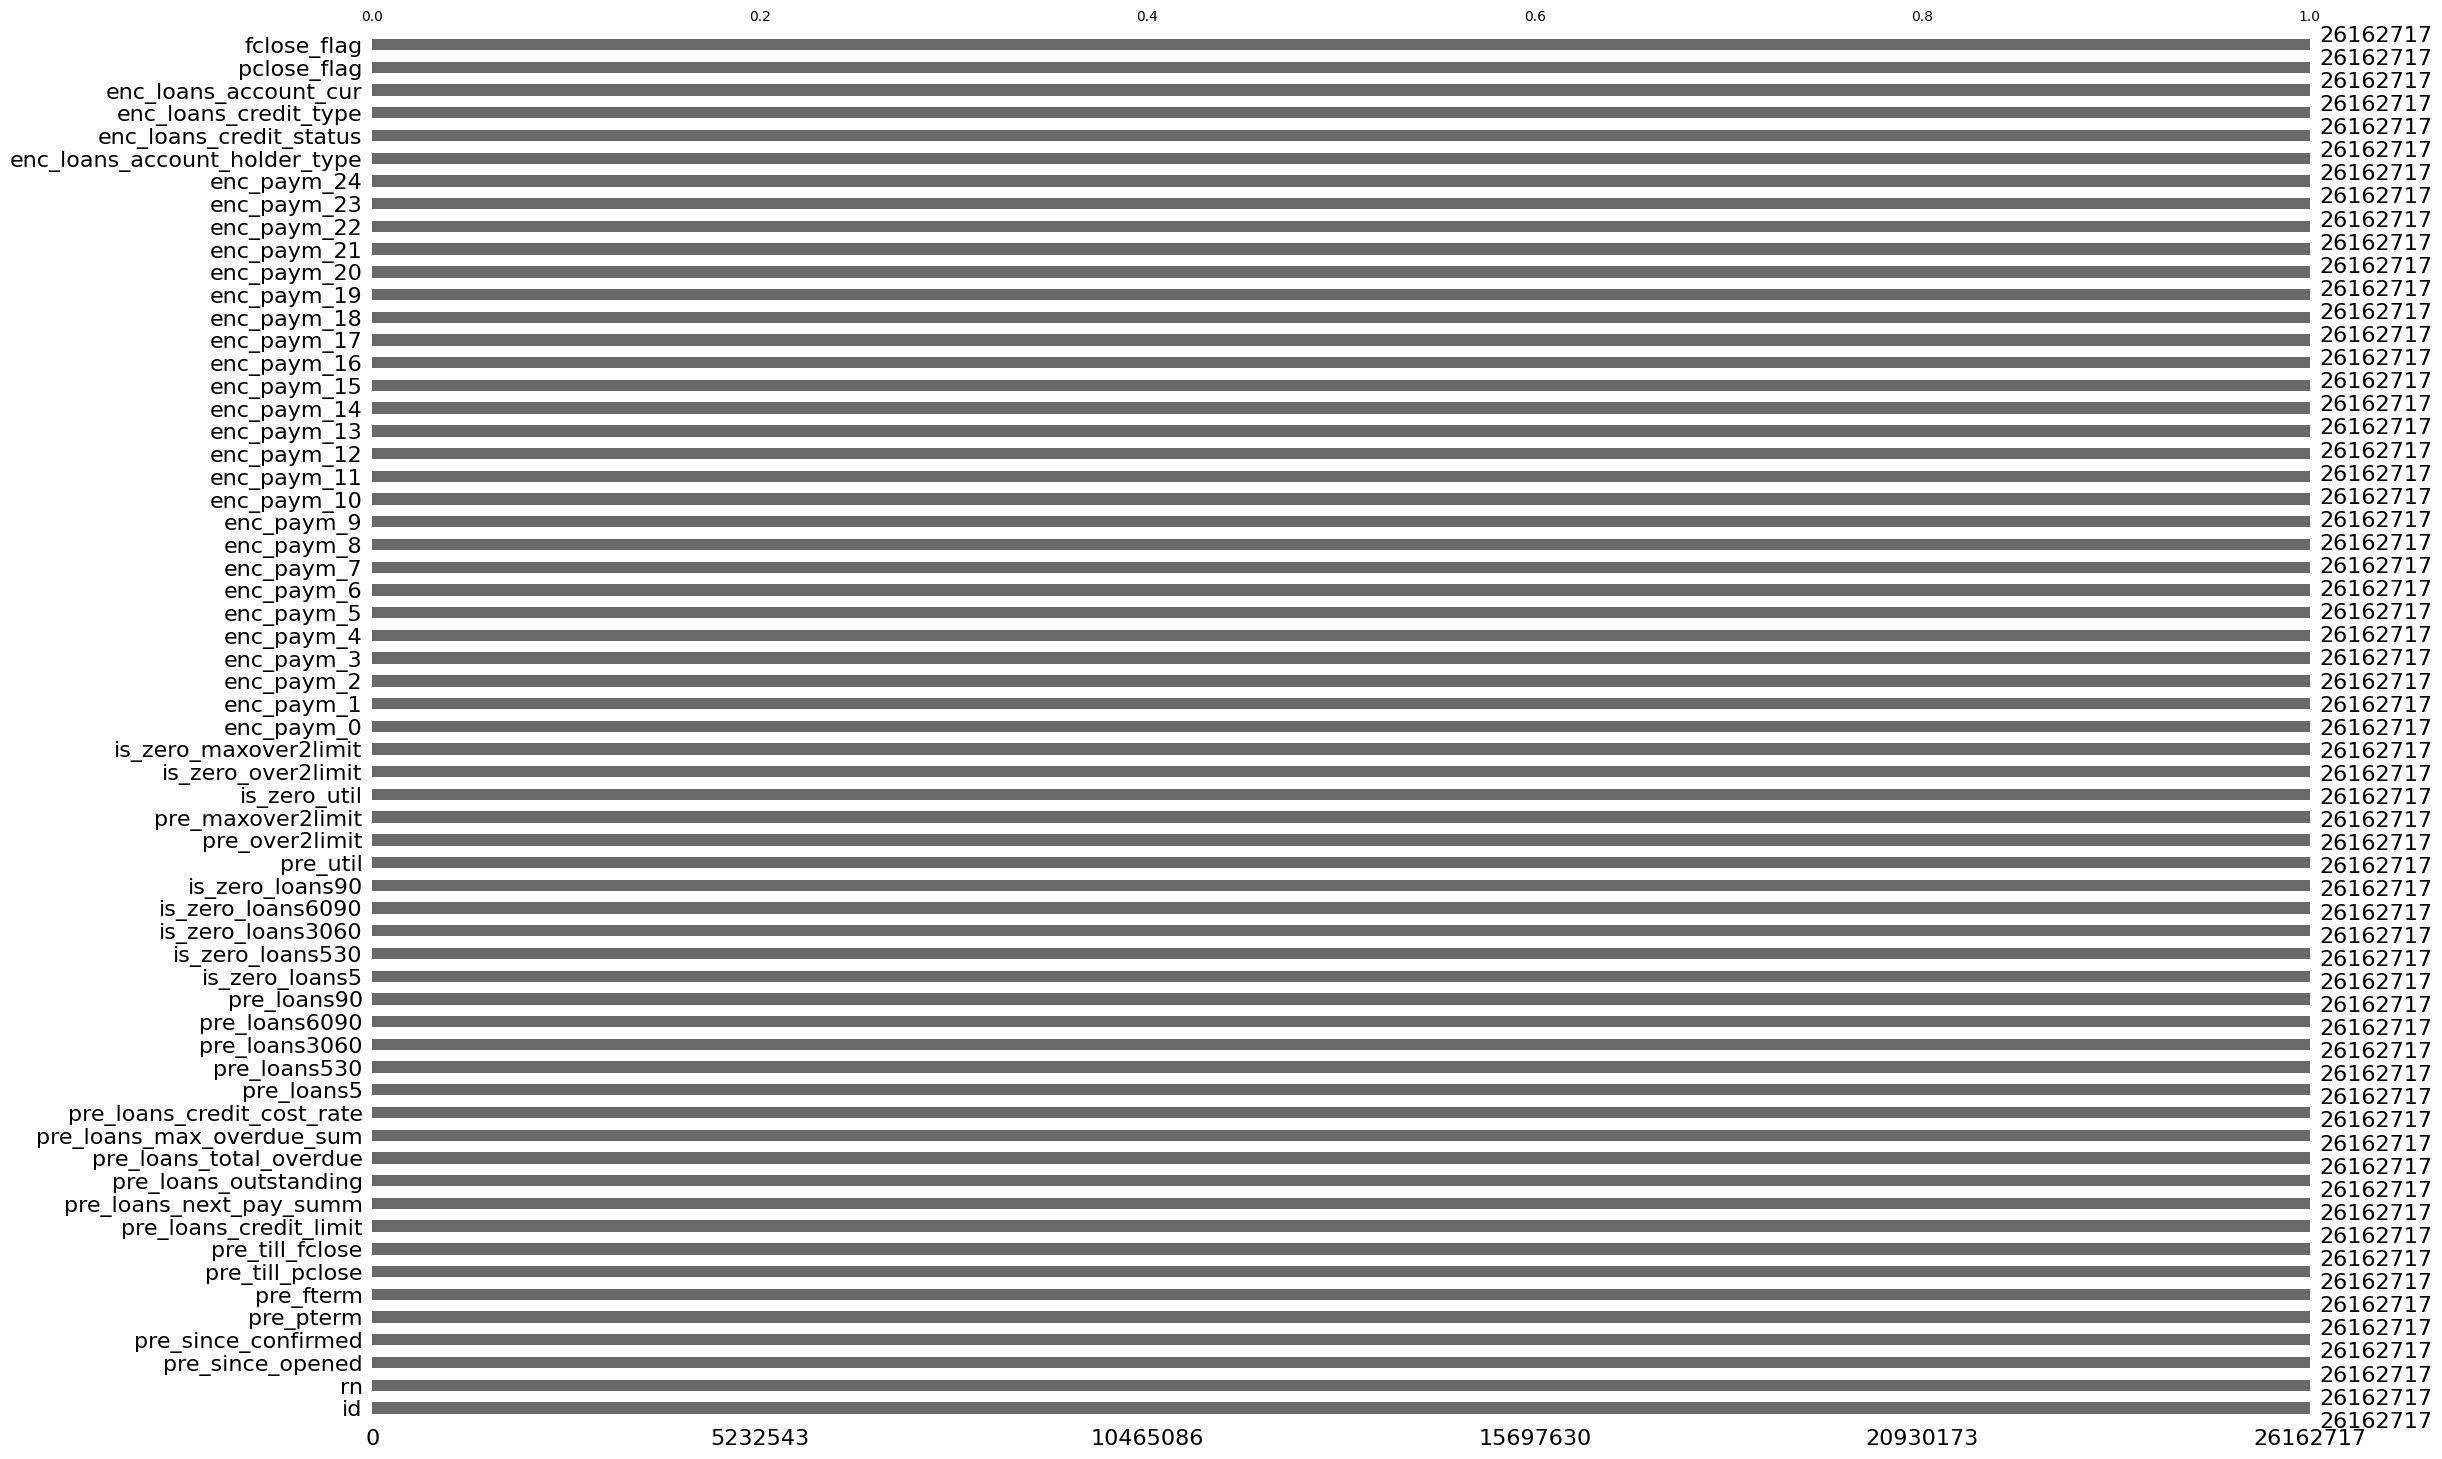

In [5]:
# Визуализируем полноту заполнения колонок
msno.bar(df);

In [6]:
# Функция, показывающая процент пропущенных значений в колонках
def persent_missing_values(df):
    missing_values = (round((df.isna().sum() / len(df)) * 100, 2)).sort_values(ascending=False)
    
    if (missing_values[missing_values.values > 0]).isna().sum() != 0:
        print('Процент пропущенных значений: ')
        return missing_values[missing_values.values > 0]
    else:
        print('Пропущенных значений в датасете нет')
        
persent_missing_values(df)

Пропущенных значений в датасете нет


### 2.1.3. Нахождение выбросов и аномалий:

In [7]:
# Функция нахождения границ диапазона нормальных значений
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [9]:
# Функция нахождения значений, выходящих за границы диапазона нормальных значений
def boundaries_result(data):
    boundaries = calculate_outliers(data)
    is_outlier = (data < boundaries[0]) | (data > boundaries[1])
    print('Границы диапазона:', boundaries)
    print('Количество значений, выходящих за границы диапазона:', is_outlier.sum())

#### Нахождение выбросов и аномалий для колонки "rn":

In [10]:
boundaries_result(df['rn'])

Границы диапазона: (-7.5, 20.5)
Количество значений, выходящих за границы диапазона: 624805


In [11]:
boundaries = calculate_outliers(df['rn'])
df[(df['rn'] < boundaries[0]) | (df['rn'] > boundaries[1])]['rn'].unique()

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58], dtype=int8)

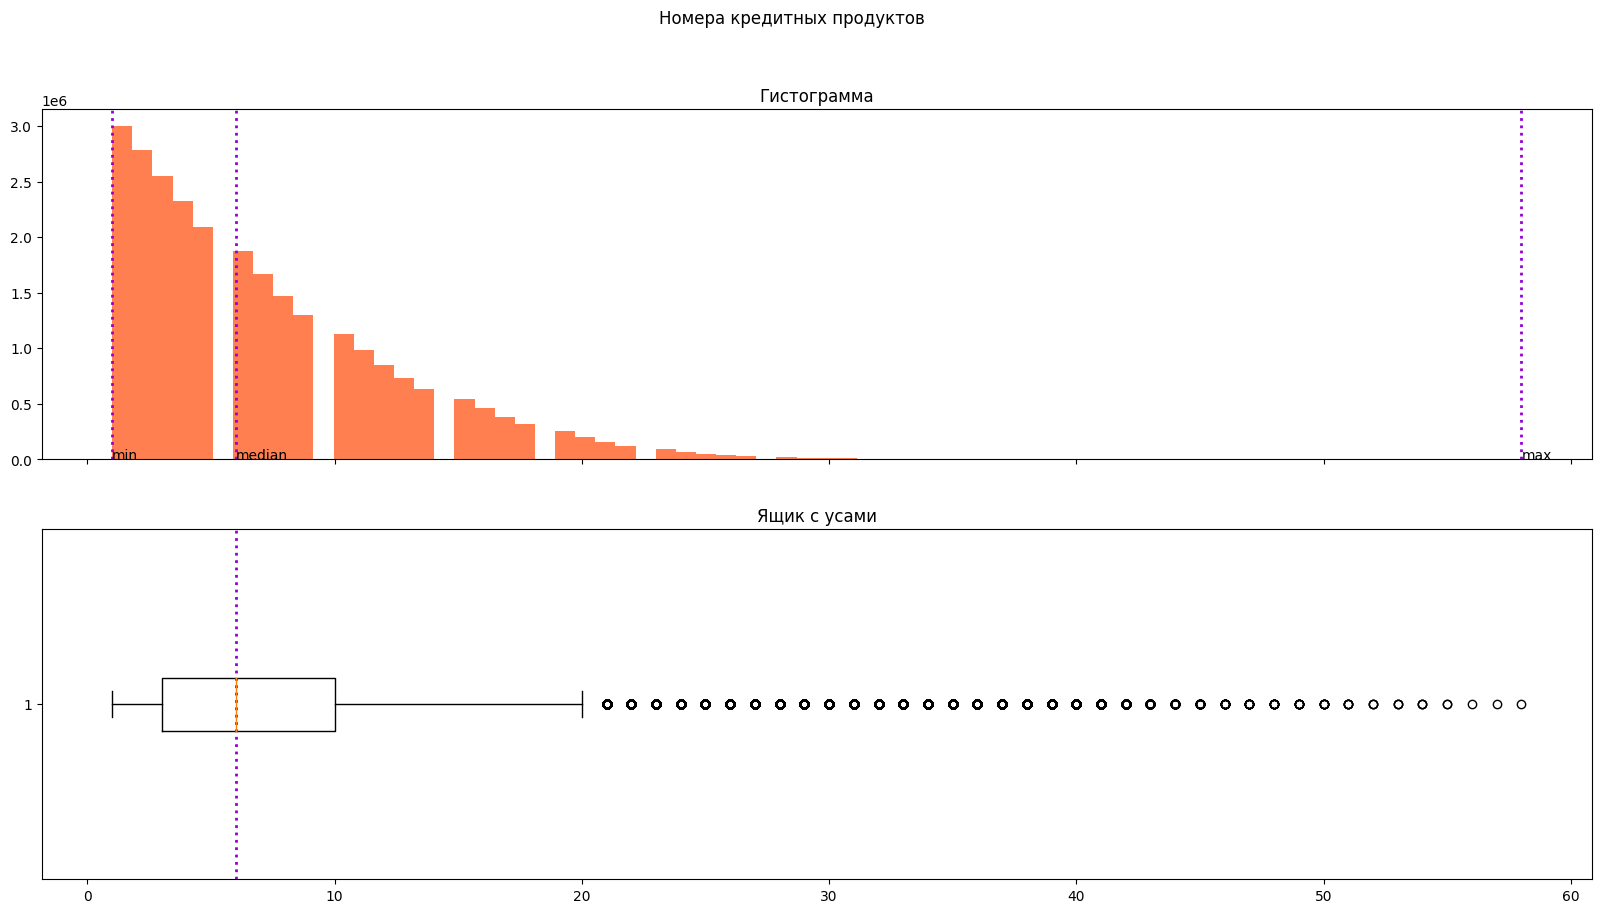

In [12]:
# Визуализация с помощью гистограммы и ящика с усами
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

ax1.hist(df['rn'], bins=70, color='coral')
ax1.set_title('Гистограмма')
ax1.axvline(df['rn'].median(), color='darkviolet', linestyle='dotted', linewidth=2)
ax1.axvline(df['rn'].min(), color='darkviolet', linestyle='dotted', linewidth=2)
ax1.axvline(df['rn'].max(), color='darkviolet', linestyle='dotted', linewidth=2)

ax1.text(df['rn'].median(),-100,'median',rotation=0)
ax1.text(df['rn'].min(),-100,'min',rotation=0)
ax1.text(df['rn'].max(),-100,'max',rotation=0)

ax2.boxplot(df['rn'], vert=False)
ax2.axvline(df['rn'].median(), color='darkviolet', linestyle='dotted', linewidth=2)
ax2.set_title('Ящик с усами')

fig.suptitle('Номера кредитных продуктов');

#### Нахождение выбросов и аномалий для остальных колонок:

In [7]:
# Создание списка категориальных признаков
columns = df.columns[2:]
columns

Index(['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm',
       'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit',
       'pre_loans_next_pay_summ', 'pre_loans_outstanding',
       'pre_loans_total_overdue', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530',
       'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5',
       'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090',
       'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit',
       'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit',
       'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4',
       'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9',
       'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13',
       'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17',
       'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
       'enc_paym_22

In [14]:
# Уникальные значения для каждого из категориальных признаков
for column in columns:
    print(column, ': ', df[column].unique())

pre_since_opened :  [18  4  5  3  2  1  7  8 15 14 10 13 12  0  6  9 19 17 11 16]
pre_since_confirmed :  [ 9  1 12  0  7  3  4 14  6  8  5 16  2 10 17 11 13 15]
pre_pterm :  [ 2 14  4  9 15 11  1 12 13  7  8  0 16 17 10  6  3  5]
pre_fterm :  [ 3 14  8 12  2 13 10 15  6  0 11  9  1 16  7  5  4]
pre_till_pclose :  [16 12  1 11 14  8  9 13  6 15  7  3  2  5  4 10  0]
pre_till_fclose :  [10 12 11  7 14  8  1 13  5  3 15  2  6  9  0  4]
pre_loans_credit_limit :  [11  0 12 10  4 15  2 16  1  6  3 14 19 13 18  5 17  8  7  9]
pre_loans_next_pay_summ :  [3 0 2 5 4 1 6]
pre_loans_outstanding :  [3 5 1 2 4]
pre_loans_total_overdue :  [0 1]
pre_loans_max_overdue_sum :  [2 1 3 0]
pre_loans_credit_cost_rate :  [11  8  4  3 13  0  7  5  9  1  2 10  6 12]
pre_loans5 :  [ 6  0  5  3  2 16 13  7  1  9  8 11 10]
pre_loans530 :  [16  2  0  6 13 18 12  4  3  1 15 14 10 11  7 19  9 17  5  8]
pre_loans3060 :  [5 8 9 2 7 1 3 0 4 6]
pre_loans6090 :  [4 1 2 3 0]
pre_loans90 :  [ 8 14 13 19  2 10  3]
is_zero_lo

## 2.2. Feature engineering:

### 2.2.1. Преобразование категориальных данных:

In [8]:
# Преобразование с помощью OneHotEncoder
id_df = df[['id']]
data_df = id_df.groupby(['id']).agg(func=sum)

ohe = OneHotEncoder(sparse=False)

for column in columns:
    data = df[[column]] 
    
    ohe.fit(data)
    ohe_data = ohe.transform(data)
    
    id_df[ohe.get_feature_names_out()] = ohe_data.astype('int8')
    id_df = id_df.groupby(['id']).agg(func=sum)
    
    data_df = data_df.merge(id_df, left_on='id', right_on='id', how='inner')
    id_df = df[['id']]

data_df.head(5)

,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,2,0,1,0,0,...,0,0,0,10,0,0,9,1,8,2
1,0,0,1,0,0,0,0,1,2,0,...,0,0,0,14,0,0,13,1,12,2
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,1,2,1,2
3,0,3,1,0,2,1,3,0,0,0,...,0,0,0,15,0,0,10,5,9,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1


### 2.2.2. Агрегация признака "rn":

In [9]:
# Выделение максимального номера кредитного продукта для каждого клиента
rn_df = df[['id', 'rn']].groupby(['id']).agg(func=max)
rn_df

,rn
id,
0,10
1,14
2,3
3,15
4,1
...,...
2999995,11
2999996,13
2999997,10


In [10]:
# Добавление максимального номера кредитного продукта для каждого клиента в датасет
df = data_df.merge(rn_df, left_on='id', right_on='id', how='inner')
df.head()

,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1,rn
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,2,0,1,0,0,...,0,0,10,0,0,9,1,8,2,10
1,0,0,1,0,0,0,0,1,2,0,...,0,0,14,0,0,13,1,12,2,14
2,1,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,1,2,1,2,3
3,0,3,1,0,2,1,3,0,0,0,...,0,0,15,0,0,10,5,9,6,15
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,1


### 2.2.3. Добавление целевой переменной в датасет:

In [11]:
# Чтение из файла значений целевой переменной
target = pd.read_csv('/kaggle/input/target/train_target.csv')
target.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [12]:
# Преобразование типа целевой переменной для сокращения используемой памяти
target['flag'] = target['flag'].astype('int8')
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int64
 1   flag    int8 
dtypes: int64(1), int8(1)
memory usage: 25.7 MB


In [13]:
# Добавление целевой переменной в датасет
df = df.merge(target, left_on='id', right_on='id', how='inner')
df.head()

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1,rn,flag
0,0,0,1,1,1,1,2,0,1,0,...,0,10,0,0,9,1,8,2,10,0
1,1,0,0,1,0,0,0,0,1,2,...,0,14,0,0,13,1,12,2,14,0
2,2,1,0,0,0,0,0,0,0,0,...,0,3,0,0,1,2,1,2,3,0
3,3,0,3,1,0,2,1,3,0,0,...,0,15,0,0,10,5,9,6,15,0
4,4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0


In [14]:
# Дисбаланс классов итогового датасета
df['flag'].value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

### 2.2.4. Сохранение финального датасета:

In [15]:
# Сохранение полученного датасета в pickle-файл
filename = 'df_final.pickle'

with open(filename, 'wb') as file:
    pickle.dump(df, file)

In [15]:
# Чтение всего датасета из pickle-файла
df = pd.read_pickle('/kaggle/working/df_final.pickle')
df.head()

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1,rn,flag
0,0,0,1,1,1,1,2,0,1,0,...,0,10,0,0,9,1,8,2,10,0
1,1,0,0,1,0,0,0,0,1,2,...,0,14,0,0,13,1,12,2,14,0
2,2,1,0,0,0,0,0,0,0,0,...,0,3,0,0,1,2,1,2,3,0
3,3,0,3,1,0,2,1,3,0,0,...,0,15,0,0,10,5,9,6,15,0
4,4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0


In [24]:
# Размер финального датасета
df.shape

(3000000, 422)

### 2.2.5. Разделение данных на train и test:

In [16]:
X = df.drop(['id', 'flag'], axis=1)
y = df['flag']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=df['flag'])

In [27]:
print('X_train:', X_train.shape, '| y_train:', y_train.shape)
print('X_test:', X_test.shape, '  | y_test:', y_test.shape)

X_train: (2400000, 420) | y_train: (2400000,)
X_test: (600000, 420)   | y_test: (600000,)


### 2.2.6. Нормализация данных:

In [18]:
# Нормализация тренировочных данных с помощью StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(X_train[['rn']])
std_scaled_train = std_scaler.transform(X_train[['rn']])

X_train['rn_std'] = std_scaled_train
X_train = X_train.drop('rn', axis=1)
X_train.head()

,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1,rn_std
798317,0,1,3,0,1,0,0,0,0,0,...,0,0,7,0,0,7,0,5,2,-0.278351
75142,0,0,2,0,1,0,0,0,0,0,...,0,0,5,0,0,3,2,3,2,-0.602109
2808376,2,0,0,1,0,1,1,0,0,2,...,0,0,17,0,0,12,5,14,3,1.340442
2545795,0,0,2,0,0,1,0,1,1,0,...,0,0,6,0,0,6,0,5,1,-0.440230
1745858,2,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,1,2,1,2,-0.925868


In [19]:
# Нормализация тестовых данных с помощью StandardScaler
std_scaled_test = std_scaler.transform(X_test[['rn']])

X_test['rn_std'] = std_scaled_test
X_test = X_test.drop('rn', axis=1)
X_test.head()

,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1,rn_std
2407614,2,1,0,1,0,0,0,0,0,1,...,0,0,5,0,0,2,3,2,3,-0.602109
1687029,0,1,0,0,1,0,2,1,0,0,...,0,0,9,0,0,9,0,9,0,0.045408
1447093,0,2,7,1,0,0,3,3,0,2,...,1,0,24,0,0,19,5,21,3,2.473596
662319,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,-1.249626
110172,1,0,0,1,0,1,0,0,2,0,...,0,0,8,0,0,7,1,5,3,-0.116472


# 3. Modelling:

In [16]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.3)

In [17]:
del X_train_train, y_train_train

print('X_train_part:', X_train_test.shape, '| y_train_part:', y_train_test.shape)

X_train_part: (720000, 420) | y_train_part: (720000,)


## 3.1.  Модели без тюнинга параметров:

### 3.1.1. RandomForestClassifier:

In [30]:
model = RandomForestClassifier()
model.fit(X_train_test, y_train_test)

pred_train = model.predict_proba(X_train_test)[:,1]
print('Train:', roc_auc_score(y_train_test, pred_train))

pred_test = model.predict_proba(X_test)[:,1]
print('Test:', roc_auc_score(y_test, pred_test))

Train: 0.999983958645315
Test: 0.6945644434276339


### 3.1.2. Histogram-Based Gradient Boosting:

In [31]:
model = HistGradientBoostingClassifier()
model.fit(X_train_test, y_train_test)

pred_train = model.predict_proba(X_train_test)[:,1]
print('Train:', roc_auc_score(y_train_test, pred_train))

pred_test = model.predict_proba(X_test)[:,1]
print('Test:', roc_auc_score(y_test, pred_test))

Train: 0.787859958966018
Test: 0.7521447879670886


### 3.1.3. LightGBM:

In [32]:
model = LGBMClassifier()
model.fit(X_train_test, y_train_test)

pred_train = model.predict_proba(X_train_test)[:,1]
print('Train:', roc_auc_score(y_train_test, pred_train))

pred_test = model.predict_proba(X_test)[:,1]
print('Test:', roc_auc_score(y_test, pred_test))

Train: 0.7873821489079967
Test: 0.7530563857710267


### 3.1.4. CatBoost:

In [33]:
model = CatBoostClassifier(iterations=50)
model.fit(X_train_test, y_train_test)

pred_train = model.predict_proba(X_train_test)[:,1]
print('Train:', roc_auc_score(y_train_test, pred_train))

pred_test = model.predict_proba(X_test)[:,1]
print('Test:', roc_auc_score(y_test, pred_test))

Learning rate set to 0.5
0:	learn: 0.2343547	total: 518ms	remaining: 25.4s
1:	learn: 0.1656552	total: 1.05s	remaining: 25.2s
2:	learn: 0.1507941	total: 1.73s	remaining: 27.1s
3:	learn: 0.1455474	total: 2.53s	remaining: 29.1s
4:	learn: 0.1437666	total: 3.7s	remaining: 33.3s
5:	learn: 0.1430436	total: 4.58s	remaining: 33.6s
6:	learn: 0.1422379	total: 5.41s	remaining: 33.2s
7:	learn: 0.1417177	total: 6.13s	remaining: 32.2s
8:	learn: 0.1413848	total: 6.83s	remaining: 31.1s
9:	learn: 0.1410974	total: 7.49s	remaining: 29.9s
10:	learn: 0.1408835	total: 8.11s	remaining: 28.8s
11:	learn: 0.1406909	total: 8.86s	remaining: 28.1s
12:	learn: 0.1405011	total: 9.49s	remaining: 27s
13:	learn: 0.1402825	total: 10.1s	remaining: 25.9s
14:	learn: 0.1401136	total: 10.9s	remaining: 25.3s
15:	learn: 0.1399345	total: 11.5s	remaining: 24.5s
16:	learn: 0.1398352	total: 12s	remaining: 23.3s
17:	learn: 0.1396781	total: 12.8s	remaining: 22.8s
18:	learn: 0.1395504	total: 13.8s	remaining: 22.5s
19:	learn: 0.1395121	

## 3.2. Подбор параметров:

### 3.2.1. Histogram-Based Gradient Boosting:

In [34]:
params = {'max_iter' : [60, 90],
          'max_depth' : [5, 10]}

gs = GridSearchCV(HistGradientBoostingClassifier(random_state=42, class_weight='balanced'), params, cv=3, scoring='roc_auc', n_jobs=-1)

gs.fit(X_train_test, y_train_test)
print('Best score:', gs.best_score_)
print('Best estimator:', gs.best_estimator_)

Best score: 0.7514219441892246
Best estimator: HistGradientBoostingClassifier(class_weight='balanced', max_depth=10,
                               max_iter=90, random_state=42)


### 3.2.2. LightGBM:

In [35]:
params = {'num_leaves' : [48, 64],
          'max_depth' : [5, 10],
          'learning_rate': [0.05, 0.1]}

gs = GridSearchCV(LGBMClassifier(random_state=42, class_weight='balanced', objective='binary'), params, cv=3, scoring='roc_auc', n_jobs=-1)

gs.fit(X_train_test, y_train_test)
print('Best score:', gs.best_score_)
print('Best estimator:', gs.best_estimator_)

Best score: 0.7517131338073447
Best estimator: LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=10,
               num_leaves=64, objective='binary', random_state=42)


## 3.3. Модели после тюнинга параметров:

### 3.3.1. Histogram-Based Gradient Boosting:

In [12]:
model = HistGradientBoostingClassifier(class_weight='balanced', max_depth=10, max_iter=90, random_state=42)
model.fit(X_train, y_train)

pred_train = model.predict_proba(X_train)[:,1]
print('Train:', roc_auc_score(y_train, pred_train))

pred_test = model.predict_proba(X_test)[:,1]
print('Test:', roc_auc_score(y_test, pred_test))

Train: 0.7652558409625418
Test: 0.7563341707220772


In [13]:
cv_score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
cv_score

array([0.75855738, 0.75569329, 0.75616936])

In [14]:
cv_score.mean(), cv_score.std()

(0.7568066764992137, 0.0012530995652680816)

### 3.3.2. LightGBM:

In [9]:
model = LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=10,
                       num_leaves=64, objective='binary', random_state=42)
model.fit(X_train, y_train)

pred_train = model.predict_proba(X_train)[:,1]
print('Train:', roc_auc_score(y_train, pred_train))

pred_test = model.predict_proba(X_test)[:,1]
print('Test:', roc_auc_score(y_test, pred_test))

Train: 0.7660458249008022
Test: 0.7550859014831048


In [10]:
cv_score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
cv_score

array([0.75739598, 0.75392852, 0.75470817])

In [11]:
cv_score.mean(), cv_score.std()

(0.7553442245607732, 0.0014853160630174896)

## 3.4. Нейронная сеть:

In [18]:
X_train_test = X_train_test.to_numpy()
y_train_test = y_train_test.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [19]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    
train_data = MyDataset(X_train_test, y_train_test)

In [20]:
batch_size = 50000

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

for i, (X_batch, y_batch) in enumerate(train_dataloader):
    print(f'batch #{i}, X_shape: {X_batch.shape}, y_shape: {y_batch.shape}')

batch #0, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #1, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #2, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #3, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #4, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #5, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #6, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #7, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #8, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #9, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #10, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #11, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #12, X_shape: torch.Size([50000, 420]), y_shape: torch.Size([50000])
batch #13, X_shape: torch.Size([500

In [21]:
class MyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        self.f1 = nn.Sigmoid()
        
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.f2 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.f1(self.hidden(x))
        x = self.f2(self.output(x))
        
        return x

In [22]:
my_net = MyNet(420, 16, 1)

print(my_net)

MyNet(
  (hidden): Linear(in_features=420, out_features=16, bias=True)
  (f1): Sigmoid()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (f2): Sigmoid()
)


In [23]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(my_net.parameters(), lr=0.5)

In [24]:
num_epochs = 50

loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        
        pred = my_net(X)
        
        loss = loss_fn(pred, y.unsqueeze(-1))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    loss = loss_fn(pred, y.unsqueeze(-1))
    loss_values.append(loss.item())

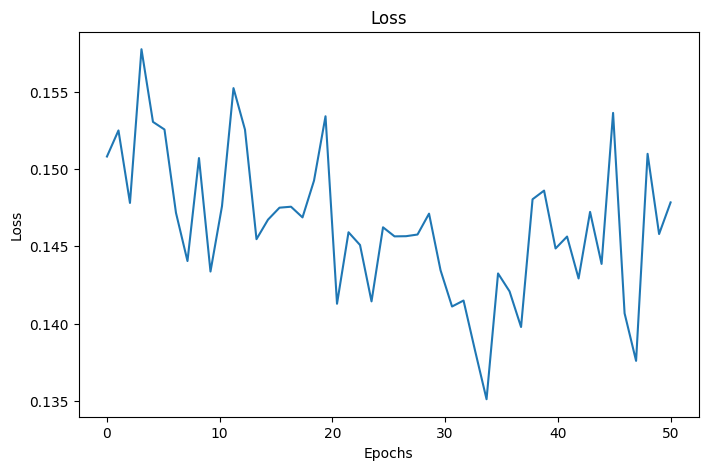

In [25]:
step = np.linspace(0, num_epochs)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:
with torch.no_grad():
    y_pred = my_net(torch.from_numpy(X_test.astype(np.float32)))
    
y = y_pred.detach().numpy()
print(roc_auc_score(y_test, y))

0.7163875433653599


# 4. Results:

## 4.1. Лучшая модель:

In [11]:
model = HistGradientBoostingClassifier(class_weight='balanced', max_depth=10, max_iter=90, random_state=42)
model.fit(X_train, y_train)

pred_train = model.predict_proba(X_train)[:,1]
print('Train', roc_auc_score(y_train, pred_train))

pred_test = model.predict_proba(X_test)[:,1]
print('Test', roc_auc_score(y_test, pred_test))

Train 0.7652558409625418
Test 0.7563341707220772


## 4.2. Создание файла с предиктами на тестовой выборке:

In [12]:
print(pred_test)

for i in range(len(pred_test)):
    if pred_test[i] < 0.5:
        pred_test[i] = 0
    else:
        pred_test[i] = 1
        
print(pred_test)

[0.39322312 0.3653799  0.51167454 ... 0.43138674 0.5727904  0.42532023]
[0. 0. 1. ... 0. 1. 0.]


In [13]:
pred_test = pd.DataFrame({'Predict': pred_test[:]})
pred_test 

,Predict
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
599995,0.0
599996,1.0
599997,0.0
599998,1.0


In [14]:
pred_test.to_csv('predictions.csv', index=True)

# 5. Pipeline:

In [6]:
def transform_cols(df):
    import pandas as pd
    
    columns = df.columns[2:]
    
    id_df = df[['id']]
    data_df = id_df.groupby(['id']).agg(func=sum)

    ohe = OneHotEncoder(sparse=False)

    for column in columns:
        data = df[[column]] 

        ohe.fit(data)
        ohe_data = ohe.transform(data)

        id_df[ohe.get_feature_names_out()] = ohe_data.astype('int8')
        id_df = id_df.groupby(['id']).agg(func=sum)

        data_df = data_df.merge(id_df, left_on='id', right_on='id', how='inner')
        id_df = df[['id']]
        
    rn_df = df[['id', 'rn']].groupby(['id']).agg(func=max)
    df = data_df.merge(rn_df, left_on='id', right_on='id', how='inner')

    return df

In [7]:
X = pd.read_pickle('/kaggle/input/df-pickle/df.pickle')
X.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [8]:
target = pd.read_csv('/kaggle/input/target/train_target.csv')
y = target['flag'].astype('int8')

pipe = Pipeline(steps=[
    ('transform_cols', FunctionTransformer(transform_cols)),
    ('classifier', HistGradientBoostingClassifier(class_weight='balanced', max_depth=10, 
                                                  max_iter=90, random_state=42))
])

pipe.fit(X, y)

Pipeline(steps=[('transform_cols',
                 FunctionTransformer(func=<function transform_cols at 0x7ef6fd317760>)),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_depth=10, max_iter=90,
                                                random_state=42))])

In [9]:
predictions = pipe.predict(X)
predictions

array([0, 1, 1, ..., 1, 1, 1], dtype=int8)

In [10]:
filename = 'pipeline.pkl'

with open(filename, 'wb') as file:
    pickle.dump(pipe, file)